In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install transformers

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import AdamW

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
import string
from nltk.corpus import stopwords
from collections import Counter
from nltk.stem import WordNetLemmatizer
import re

from transformers import AutoModel, AutoTokenizer

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import random
import os

from tqdm import tqdm

## Pass random state

In [ ]:
random_state = 101

def seed_everything(seed: int,
                    use_deterministic_algos: bool = False) -> None:

    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.use_deterministic_algorithms(use_deterministic_algos)
    random.seed(seed)


seed_everything(random_state)

In [ ]:
class Args():
    def __init__(self):
        self.max_length = 128
        self.lr = 1e-5
        self.num_epochs = 1
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.batch_size = 8
        self.model_name = "ai-forever/ruRoberta-large"
        self.random_state = 101

args = Args()
args.device

device(type='cuda')

## Data

In [ ]:
df = pd.read_csv('/content/dataset_for_train.csv')

In [ ]:
df.head()

,text,label
0,стартап болезнь 1 самом начале пути стартап не...,бизнес и стартап
1,допустить глупых ошибок пресиде очень многое з...,бизнес и стартап
2,хочу напомнить чат можете вакансию разместить ...,бизнес и стартап
3,🦄доброе утро наши маленькие любители единорого...,бизнес и стартап
4,компания выпускающая мёрч фанатов спортивных к...,бизнес и стартап


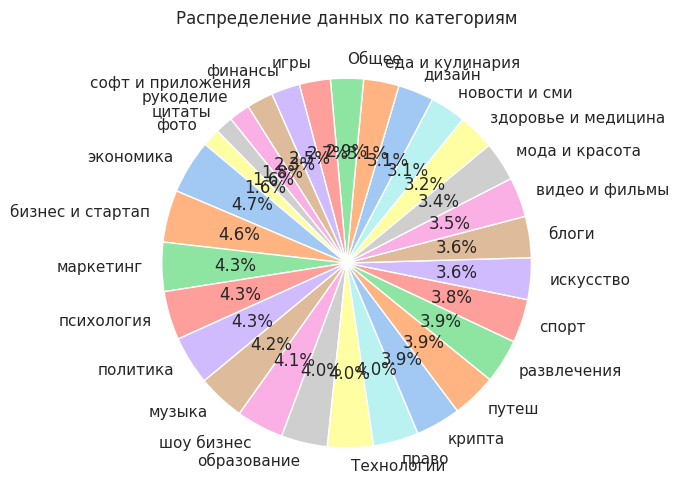

In [ ]:
label_counts = df['label'].value_counts()

plt.figure(figsize=(6, 6))
sns.set(style="whitegrid")
sns.set_palette("pastel")
plt.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Распределение данных по категориям')
plt.show()

## Label encoder

In [ ]:
id_to_label = {0: 'Общее',
 1: 'Технологии',
 2: 'бизнес и стартап',
 3: 'блоги',
 4: 'видео и фильмы',
 5: 'дизайн',
 6: 'еда и кулинария',
 7: 'здоровье и медицина',
 8: 'игры',
 9: 'искусство',
 10: 'крипта',
 11: 'маркетинг',
 12: 'мода и красота',
 13: 'музыка',
 14: 'новости и сми',
 15: 'образование',
 16: 'политика',
 17: 'право',
 18: 'психология',
 19: 'путеш',
 20: 'развлечения',
 21: 'рукоделие',
 22: 'софт и приложения',
 23: 'спорт',
 24: 'финансы',
 25: 'фото',
 26: 'цитаты',
 27: 'шоу бизнес',
 28: 'экономика'}

In [ ]:
label_to_id = { id_to_label[x]:x for x in id_to_label.keys()}
label_to_id

{'Общее': 0,
 'Технологии': 1,
 'бизнес и стартап': 2,
 'блоги': 3,
 'видео и фильмы': 4,
 'дизайн': 5,
 'еда и кулинария': 6,
 'здоровье и медицина': 7,
 'игры': 8,
 'искусство': 9,
 'крипта': 10,
 'маркетинг': 11,
 'мода и красота': 12,
 'музыка': 13,
 'новости и сми': 14,
 'образование': 15,
 'политика': 16,
 'право': 17,
 'психология': 18,
 'путеш': 19,
 'развлечения': 20,
 'рукоделие': 21,
 'софт и приложения': 22,
 'спорт': 23,
 'финансы': 24,
 'фото': 25,
 'цитаты': 26,
 'шоу бизнес': 27,
 'экономика': 28}

In [ ]:
df['label'].value_counts()

экономика              4540
бизнес и стартап       4385
маркетинг              4121
психология             4087
политика               4084
музыка                 3987
шоу бизнес             3966
образование            3877
Технологии             3845
право                  3811
крипта                 3767
путеш                  3739
развлечения            3713
спорт                  3661
искусство              3490
блоги                  3466
видео и фильмы         3340
мода и красота         3303
здоровье и медицина    3054
новости и сми          3007
дизайн                 2993
еда и кулинария        2970
Общее                  2760
игры                   2611
финансы                2402
софт и приложения      2218
рукоделие              1768
цитаты                 1492
фото                   1489
Name: label, dtype: int64

In [ ]:
df['label'] = df['label'].map(label_to_id)

In [ ]:
df['label'].value_counts()

28    4540
2     4385
11    4121
18    4087
16    4084
13    3987
27    3966
15    3877
1     3845
17    3811
10    3767
19    3739
20    3713
23    3661
9     3490
3     3466
4     3340
12    3303
7     3054
14    3007
5     2993
6     2970
0     2760
8     2611
24    2402
22    2218
21    1768
26    1492
25    1489
Name: label, dtype: int64

In [ ]:
df['label'].value_counts().shape

(29,)

## Text preprocessing

In [ ]:
nltk.download('stopwords')
STOPWORDS = set(stopwords.words('russian'))

def preprocessing_text(text):
    if type(text) != str:
        return ''
    # text to lower case
    text = text.lower()
    # Remocal english words
    text = output_string = re.sub(r'[a-zA-Z]', '', text)
    # remove punctuation
    text = text.replace('\n', ' ').replace('—', '').replace('«', '')
    PUNCT_TO_REMOVE = string.punctuation
    text = text.translate(str.maketrans('', '', PUNCT_TO_REMOVE))
    # Removal of stopwords
    text = " ".join([word for word in str(text).split() if word not in STOPWORDS])
    #Removal of Emojis
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"
                           u"\U0001F300-\U0001F5FF"
                           u"\U0001F680-\U0001F6FF"
                           u"\U0001F1E0-\U0001F1FF"
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r'', text)

    # Remove urls
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    text = url_pattern.sub(r'', text)

    return text

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
df['prepared_text'] = df['text'].apply(preprocessing_text)

In [ ]:
df.head(3)

,text,label,prepared_text
0,стартап болезнь 1 самом начале пути стартап не...,2,стартап болезнь 1 самом начале пути стартап не...
1,допустить глупых ошибок пресиде очень многое з...,2,допустить глупых ошибок пресиде очень многое з...
2,хочу напомнить чат можете вакансию разместить ...,2,хочу напомнить чат можете вакансию разместить ...


In [ ]:
prepared_df = df[['prepared_text', 'label']]

## Custom DataSet

In [ ]:
class CustomDataset():
    def __init__(self, data: pd.DataFrame, tokenizer: AutoTokenizer, max_length: int):
        self.data = data
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, idx: int):
        text = self.data.iloc[idx, 0]
        label = self.data.iloc[idx, 1]

        encoded_text = self.tokenizer(text, truncation=True, padding='max_length', max_length=self.max_length, return_tensors='pt')

        return {
            'input_ids': encoded_text['input_ids'].squeeze(),
            'label': torch.tensor(label, dtype=torch.long)
        }

## Load model

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(args.model_name)
bert = AutoModel.from_pretrained(args.model_name)

Some weights of RobertaModel were not initialized from the model checkpoint at ai-forever/ruRoberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Train test split

In [ ]:
train_df, valid_df = train_test_split(prepared_df, test_size=0.2, shuffle=True, random_state=args.random_state)
train_df.shape, valid_df.shape

((76756, 2), (19190, 2))

In [ ]:
train_dataset = CustomDataset(train_df, tokenizer, args.max_length)
valid_dataset = CustomDataset(valid_df, tokenizer, args.max_length)

train_dataloader = DataLoader(train_dataset, batch_size=args.batch_size, shuffle=True, drop_last=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=args.batch_size, shuffle=True, drop_last=True)

In [ ]:
next(iter(train_dataloader))['input_ids'].shape

torch.Size([8, 128])

## Model implementation

In [ ]:
class MegaModel(nn.Module):
    def __init__(self, bert, out_dim):
        super().__init__()
        self.bert = bert
        self.emb_dim = self.bert.embeddings.word_embeddings.weight.shape[-1]
        self.out = nn.Linear(self.emb_dim, out_dim)

    def forward(self, input):
        emb = self.bert(input).last_hidden_state[:, 0, :]
        emb = torch.nn.functional.normalize(emb)
        return self.out(emb)

## Training

In [ ]:
from transformers import get_cosine_schedule_with_warmup
from sklearn.metrics import f1_score

In [ ]:
def train(args, dataloader: DataLoader, model, optimizer, loss_function, scheduler):
    model.to(args.device)
    model.train()

    loss_function.to(args.device)

    for epoch in range(args.num_epochs):
        pbar = tqdm(dataloader, desc=f'Training epoch {epoch + 1}', total=len(dataloader))


        preds = []
        targets = []

        dl_size = len(dataloader)

        total_train_loss = 0.0

        for batch_idx, batch in enumerate(pbar):

            inputs = batch['input_ids'].to(args.device)
            labels = batch['label'].to(args.device)

            optimizer.zero_grad()
            outputs = model(inputs)

            probabilities = F.softmax(outputs, dim=1)
            predicted_class = probabilities.argmax(dim=1)

            preds.append(predicted_class)
            targets.append(labels)


            loss = loss_function(outputs, labels)
            total_train_loss += loss.item()

            loss.backward()

            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            scheduler.step()

        preds = torch.cat(preds, dim=0)
        targets = torch.cat(targets, dim=0)
        acc = (targets == preds).sum() / preds.shape[0]
        f1 = f1_score(preds.cpu(), targets.cpu(), average='micro')
        f1_macro = f1_score(preds.cpu(), targets.cpu(), average='macro')

        metrics = {
            "Train Loss": total_train_loss / dl_size,
            "Train Accuracy": acc.item(),
            "Train F1_micro": f1.item(),
            "Train F1_macro": f1_macro.item()
        }

        print(metrics)

In [ ]:
checkpoint = torch.load('/content/drive/MyDrive/checkpoint_102.pth')

In [ ]:
model = MegaModel(bert, 29)
model.load_state_dict(checkpoint['model'])
model.to(args.device)

MegaModel(
  (bert): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 1024, padding_idx=1)
      (position_embeddings): Embedding(514, 1024, padding_idx=1)
      (token_type_embeddings): Embedding(1, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-23): 24 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
              (LayerNorm): 

In [ ]:
model.to(args.device)

MegaModel(
  (bert): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 1024, padding_idx=1)
      (position_embeddings): Embedding(514, 1024, padding_idx=1)
      (token_type_embeddings): Embedding(1, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-23): 24 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
              (LayerNorm): 

In [ ]:
optimizer = AdamW(
        [
            {"params": model.out.parameters(), "lr": 1e-4},
            {"params": model.bert.parameters(), "lr": 4e-6},
        ]
    )

optimizer.load_state_dict(checkpoint['optimizer'])
criterion = nn.CrossEntropyLoss().to(args.device)

In [ ]:
total_steps = len(train_dataloader)

scheduler = get_cosine_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)

In [ ]:
scheduler.load_state_dict(checkpoint['lr_sched'])

In [33]:
train(args, train_dataloader, model, optimizer, criterion, scheduler)

Training epoch 1:   0%|          | 0/9594 [00:00<?, ?it/s]We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.
You may ignore this warning if your `pad_token_id` (1) is identical to the `bos_token_id` (1), `eos_token_id` (2), or the `sep_token_id` (None), and your input is not padded.
Training epoch 1: 100%|██████████| 9594/9594 [1:58:43<00:00,  1.35it/s]


{'Train Loss': 0.43466150742823095, 'Train Accuracy': 0.8884849548339844, 'Train F1_micro': 0.888484990619137, 'Train F1_macro': 0.8846810751574359}


In [35]:
checkpoint = {
    'model': model.state_dict()
}

In [36]:
torch.save(checkpoint, '/content/drive/MyDrive/checkpoint.pth')

In [37]:
bert.save_pretrained('/content/drive/MyDrive/bert')

## Evaluate on Valid data

In [ ]:
def eval(args, dataloader: DataLoader, model):
    model.to(args.device)
    model.eval()

    pbar = tqdm(dataloader, desc='Evaluate', total=len(dataloader))

    preds = []
    targets = []

    dl_size = len(dataloader)

    total_train_loss = 0.0

    for batch_idx, batch in enumerate(pbar):

        inputs = batch['input_ids'].to(args.device)
        labels = batch['label'].to(args.device)

        outputs = model(inputs)

        preds.append(outputs.argmax(dim=1))
        targets.append(labels)

    preds = torch.cat(preds, dim=0)
    targets = torch.cat(targets, dim=0)
    acc = (targets == preds).sum() / preds.shape[0]
    f1 = f1_score(preds.cpu(), targets.cpu(), average='macro')

    metrics = {
        "Valid Accuracy": acc.item(),
        "Valid F1": f1.item()
    }

    print(metrics)

In [ ]:
eval(args, valid_dataloader, model)

## Save model

In [ ]:
checkpoint = {
    'epoch': args.num_epochs,
    'model': model.state_dict(),
    'optimizer': optimizer.state_dict(),
    'lr_sched': scheduler.state_dict()}

torch.save(checkpoint, '/content/drive/MyDrive/checkpoint_102 .pth')